In [1]:
#Import libararies

In [100]:
import numpy as np
import pandas as pd
import re
from datetime import datetime, timedelta

import pandas_ta as pta
from pandas_datareader import data as pdr


from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Normalization
import tensorflow as tf


import joblib
from google.cloud import storage

from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

In [101]:
#functions

In [200]:
def compute_rmse(y_pred, y_true):
    '''returns root mean square error'''
    return np.sqrt(((y_pred - y_true) ** 2).mean())


def compute_mpe(y_pred, y_true):
    return abs(y_pred / y_true).mean()

def get_sma(df, period=5, column='Close'):
    '''returns simple moving average of provide column and period'''
    return pta.sma(df[column],length=period)

def get_ema(df, period=10 , column='Close'):
    '''returns simple moving average of provide column and period'''
    return pta.ema(df[column], length=period)

def get_hma(df, period=10 ,column='Close'):
    '''returns simple moving average of provide column and period'''
    return pta.hma(df[column], length=period)

def get_rsi(df,period=14):
    '''returns relative strength index of provided period'''
    return pta.rsi(df['Close'], length = period)

def get_atr(df,period=14):
    '''returns average true range of provided period'''
    return pta.atr(df['High'],df['Low'],df['Close'],length=period)

def get_bband(df,period=20,std=2):
    '''returns Upper , Lower and Middle bolinger band of provided period and std'''
    return pta.bbands(df['Close'],length=period,std=std)

def get_macd(df,fast=12, slow=26, signal=9):
    '''returns Moving average convergence divergence (MACD)'''
    return pta.macd(df['Close'],fast=fast, slow=slow, signal=signal)

def get_adx(df,length=14):
    '''returns ADX of provided period'''
    return pta.adx(df['High'],df['Low'],df['Close'],length=length)

def get_vwap(df):
    '''returns Voumne weighted average'''
    return pta.vwap(df['High'],df['Low'],df['Close'], df['Volume'])

In [201]:
#Get Data
help(pta.aobv)

Help on function aobv in module pandas_ta.volume.aobv:

aobv(close, volume, fast=None, slow=None, max_lookback=None, min_lookback=None, mamode=None, offset=None, **kwargs)
    Indicator: Archer On Balance Volume (AOBV)



In [202]:
def get_technical(symbol="INFY.NS",start="2007-01-01", end="2022-03-10"):
    '''returns a DataFrame with stock technical data'''
    df = pdr.get_data_yahoo(symbol, start=start, end=end)
    df.drop(columns=['Adj Close'],inplace=True)
    

    df['ema12'] = get_ema(df, column='Close', period=12)
    df['ema21'] = get_ema(df, column='Close', period=21)
    df['ema26'] = get_ema(df, column='Close', period=26)
    df['ema34'] = get_ema(df, column='Close', period=34)
    df['ema55'] = get_ema(df, column='Close', period=55)
    df['ema99'] = get_ema(df, column='Close', period=99)
    df['ema200'] = get_ema(df, column='Close', period=200)
    df['hma12'] = get_hma(df, column='Close', period=12)
    df['hma21'] = get_hma(df, column='Close', period=21)
    df['hma26'] = get_hma(df, column='Close', period=26)
    df['hma34'] = get_hma(df, column='Close', period=34)
    df['hma55'] = get_hma(df, column='Close', period=55)
    df['hma99'] = get_hma(df, column='Close', period=99)
    df['hma200'] = get_hma(df, column='Close', period=200)
    df['rsi'] = get_rsi(df, period=14)
    df['atr'] = get_atr(df, period=14)
    df['bb_upper'] = get_bband(df, period=20, std=2)['BBU_20_2.0']
    df['bb_lower'] = get_bband(df, period=20, std=2)['BBL_20_2.0']
    df['macd_signal'] = get_macd(df, fast=12, slow=26,
                                 signal=9)['MACD_12_26_9']
    df['macd_line'] = get_macd(df, fast=12, slow=26, signal=9)['MACDs_12_26_9']
    df['adx'] = get_adx(df, length=14)['ADX_14']
    df['vwap'] = get_vwap(df)
    df = df.dropna(how='any')
    cleaned_df = df.reset_index()
    return cleaned_df

In [203]:
df = get_technical()
data = df [['Open','Close','Low','High','ema21','ema55','ema200','rsi','Volume','bb_upper','bb_lower','adx']]
data['Change'] = ((data['Close'] - data['Close'].shift())/data['Close'])*100
data = data.round(2)

/var/folders/8z/_088r0914q708yf3k91yqk940000gn/T/ipykernel_6531/643211816.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Change'] = ((data['Close'] - data['Close'].shift())/data['Close'])*100


In [204]:

data.head()

,Open,Close,Low,High,ema21,ema55,ema200,rsi,Volume,bb_upper,bb_lower,adx,Change
0,231.42,218.24,216.88,231.42,233.58,235.99,249.96,35.67,23151400.0,245.83,222.74,15.43,NaN
1,214.84,214.54,212.88,218.12,231.85,235.23,249.61,33.46,15705240.0,245.61,219.71,16.62,-1.72
2,209.38,205.23,201.27,209.38,229.43,234.16,249.17,28.64,25324832.0,247.91,213.81,18.62,-4.54
3,203.12,203.39,200.88,211.64,227.06,233.06,248.71,27.79,23517112.0,249.15,208.81,20.09,-0.90
4,210.00,213.49,207.00,216.25,225.83,232.36,248.36,38.59,16262008.0,249.14,206.84,20.71,4.73


In [205]:
#Feature engineering
#1. Distance from EMA
data['H_L'] = data['High']-data['Low']
data['C_O'] = data['Close']-data['Open']
data['d_ema21'] = data['Close']-data['ema21']
data['d_ema55'] = data['Close']-data['ema55']
data['d_ema200']= data['Close']-data['ema200']
data['d_bb_upper'] = data['Close']-data['bb_upper']
data['d_bb_lower'] = data['Close']-data['bb_upper']
data['d_High'] = data['Close']-data['High']
data['d_Low'] = data['Close']-data['Low']
data['d_Open'] = data['Close']-data['Open']

In [206]:
data= data.drop(columns=['Open','ema21','ema55','ema200','Low','High','bb_upper','bb_lower'])
data = data.dropna()
data.tail()

,Close,rsi,Volume,adx,Change,H_L,C_O,d_ema21,d_ema55,d_ema200,d_bb_upper,d_bb_lower,d_High,d_Low,d_Open
3523,1723.30,47.69,9074499.0,20.07,0.14,55.00,28.05,-5.74,-30.85,68.52,-40.39,-40.39,-12.70,42.30,28.05
3524,1739.85,50.54,9742588.0,19.72,0.95,55.00,42.85,9.83,-13.79,84.22,-23.66,-23.66,-11.15,43.85,42.85
3525,1778.20,56.47,10984500.0,18.53,2.16,81.55,59.75,43.80,23.68,121.35,4.96,4.96,-21.80,59.75,59.75
3526,1813.35,61.07,10193515.0,18.10,1.94,40.60,22.35,71.77,56.73,154.95,22.00,22.00,-18.25,22.35,22.35
3527,1825.90,62.60,6547182.0,17.97,0.69,34.55,-18.85,76.65,66.80,165.83,17.17,17.17,-18.85,15.70,-18.85


In [207]:
#Split the data to train and test

In [208]:
len_ = int(0.80*data.shape[0])
df_train_dataset = data[:len_]
df_test_dataset = data[len_:]

In [209]:
#Target is to detect % change in security in upcoming days or weeks

In [210]:
X_train_dataset = df_train_dataset.drop(columns=['Change']).to_numpy()
X_test_dataset = df_test_dataset.drop(columns=['Change']).to_numpy()

y_train=df_train_dataset['Change'].to_numpy()
y_test=df_test_dataset['Change'].to_numpy()

In [211]:
X_test_dataset.shape

(706, 14)

In [212]:
#SPlit data in time series sequence

In [213]:
TARGET_LEN = 5
SEQUENCE_SIZE = 15
def split_timeseries(scaled_data,
                         data,
                         sequence_size=21,
                         y_len=TARGET_LEN):
        # Create the training data set
        # Create the scaled training data set
        train_data = scaled_data
        y = data
        #breakpoint()
        # Split the data into x_train and y_train data sets
        x_train = []
        y_train = []

        for i in range(sequence_size, len(train_data)):
            if len(y[i:i+y_len]) < y_len:
                break

            x_train.append(train_data[i - sequence_size:i, :])
            y_train.append(y[i:i+y_len])

            if i <= sequence_size+1:
                # print(x_train)
                # print(y_train)
                print('i <= sequence_size+1')


        # Convert the x_train and y_train to numpy arrays
        x_train, y_train = np.array(x_train), np.array(y_train)
        # Reshape the data

        #y_train = np.reshape(y_train, (y_train.shape[0],Y_LEN))

        # x_train.shape
        return x_train,y_train


In [214]:
x_train, y_train = split_timeseries(X_train_dataset,
                                                y_train,
                                                sequence_size=SEQUENCE_SIZE)
x_test, y_test = split_timeseries(X_test_dataset,
                                              y_test,
                                              sequence_size=SEQUENCE_SIZE)

i <= sequence_size+1
i <= sequence_size+1
i <= sequence_size+1
i <= sequence_size+1


In [215]:
#Last 14 days memory to consider to predict future price

In [216]:
print(x_train.shape,x_test.shape)

(2802, 15, 14) (687, 15, 14)


In [217]:
#Next 5 days future price

In [218]:
print(y_train.shape,y_train.shape)

(2802, 5) (2802, 5)


In [219]:
#Model

In [220]:
def create_model(X_train, y_train):
        tf.random.set_seed(30)
        normalizer = Normalization() # Instantiate a "normalizer" layer
        normalizer.adapt(X_train) # "Fit" it on the train set
        model = Sequential()
        model.add(normalizer)
        model.add(layers.LSTM(25, return_sequences=False, input_shape=(X_train.shape[1],X_train.shape[2])))
        model.add(layers.Dropout(0.2))
        model.add(layers.Dense(15, activation='relu'))
        model.add(layers.Dropout(0.2))
        model.add(layers.Dense(TARGET_LEN, activation='linear'))
        model.compile(loss='mse',optimizer=RMSprop(learning_rate=0.02), metrics=['mae', 'mape'])
        print(model.summary())

        return model


In [221]:
model = create_model(x_train, y_train)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, None, 14)         29        
 ion)                                                            
                                                                 
 lstm_1 (LSTM)               (None, 25)                4000      
                                                                 
 dropout_2 (Dropout)         (None, 25)                0         
                                                                 
 dense_2 (Dense)             (None, 15)                390       
                                                                 
 dropout_3 (Dropout)         (None, 15)                0         
                                                                 
 dense_3 (Dense)             (None, 5)                 80        
                                                      

In [222]:
#Train the model

In [223]:
PATIENCE = 50

def train(X_train, y_train, model):
    '''returns a trained pipelined model'''
    es = EarlyStopping(patience=PATIENCE, restore_best_weights=True)
    
    #SPlit train data in train and validation to do validation with time series
    train_size = 0.9
    train_sample = int(train_size * X_train.shape[0])
    X_train, y_train, X_val, y_val = X_train[:train_sample], y_train[:train_sample], X_train[train_sample:], y_train[train_sample:]

    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, callbacks=es,batch_size=128)
    
    return model


In [224]:
 model = train(x_train, y_train, model)

Epoch 1/500
20/20 [==============================] - 2s 26ms/step - loss: 3.9594 - mae: 1.3346 - mape: 504474.3125 - val_loss: 2.2446 - val_mae: 1.1589 - val_mape: 138060.2812
Epoch 2/500
20/20 [==============================] - 0s 10ms/step - loss: 3.9355 - mae: 1.3279 - mape: 225652.7969 - val_loss: 2.2421 - val_mae: 1.1602 - val_mape: 61695.3438
Epoch 3/500
20/20 [==============================] - 0s 9ms/step - loss: 3.9345 - mae: 1.3272 - mape: 193129.0312 - val_loss: 2.2987 - val_mae: 1.1836 - val_mape: 408080.2500
Epoch 4/500
20/20 [==============================] - 0s 9ms/step - loss: 3.9334 - mae: 1.3268 - mape: 151949.3906 - val_loss: 2.2447 - val_mae: 1.1644 - val_mape: 98791.9688
Epoch 5/500
20/20 [==============================] - 0s 8ms/step - loss: 3.9305 - mae: 1.3269 - mape: 122863.8125 - val_loss: 2.2373 - val_mae: 1.1607 - val_mape: 102708.0391
Epoch 6/500
20/20 [==============================] - 0s 8ms/step - loss: 3.9344 - mae: 1.3272 - mape: 107845.7109 - val_loss:

In [225]:
#Evaluate your model performance

In [244]:
TYPE_Y ='abc'

def evaluate(x_test, y_test, model):
        '''returns the value of the RMSE'''
        y_pred = model.predict(x_test)
        print(y_pred.shape)



        if TYPE_Y == 'log':
            y_test = np.exp(y_test)
            y_pred = np.exp(y_pred)
            

        residuos = y_test - y_pred
        rmse = (residuos ** 2).mean(axis = 0) ** 0.5
        mpe = abs(y_pred / y_test).mean(axis = 0)
        mae = abs(y_pred - y_test).mean(axis = 0)
        df_pred = pd.DataFrame(y_pred).pct_change()
        df_test = pd.DataFrame(y_test).pct_change()
        df_sum_total_errors_pct = (df_pred - df_test).sum(axis = 0) * 100
        df_mean_total_errors_pct = (df_pred - df_test).mean(axis = 0) * 100
        df_max_total_errors_pct = (df_pred - df_test).max(axis = 0) * 100
        df_min_total_errors_pct = (df_pred - df_test).min(axis = 0) * 100


        #Ploting
        fig = plt.figure(figsize= (15,30))
        for i in range(1,TARGET_LEN):
            if i == 1:
                count = i
            else:
                count +=1
            #Original scale plot
            axs = fig.add_subplot(TARGET_LEN,2,count)
            axs.set_title = f'{i} days in the future'
            axs.plot(y_test[:,i-1], label= 'y_test')
            axs.plot(y_pred[:,i-1], label= 'y_pred')
            plt.legend()
            #Pct_change plot
            count +=1
            axs = fig.add_subplot(TARGET_LEN,2,count)
            axs.plot(df_pred.to_numpy()[:,i-1], label= 'y_test')
            axs.plot(df_test.to_numpy()[:,i-1], label= 'y_pred')
            plt.legend()

        plt.show()

        return mpe,df_pred,y_test

(687, 5)


/var/folders/8z/_088r0914q708yf3k91yqk940000gn/T/ipykernel_6531/1434368181.py:17: RuntimeWarning: divide by zero encountered in true_divide
  mpe = abs(y_pred / y_test).mean(axis = 0)


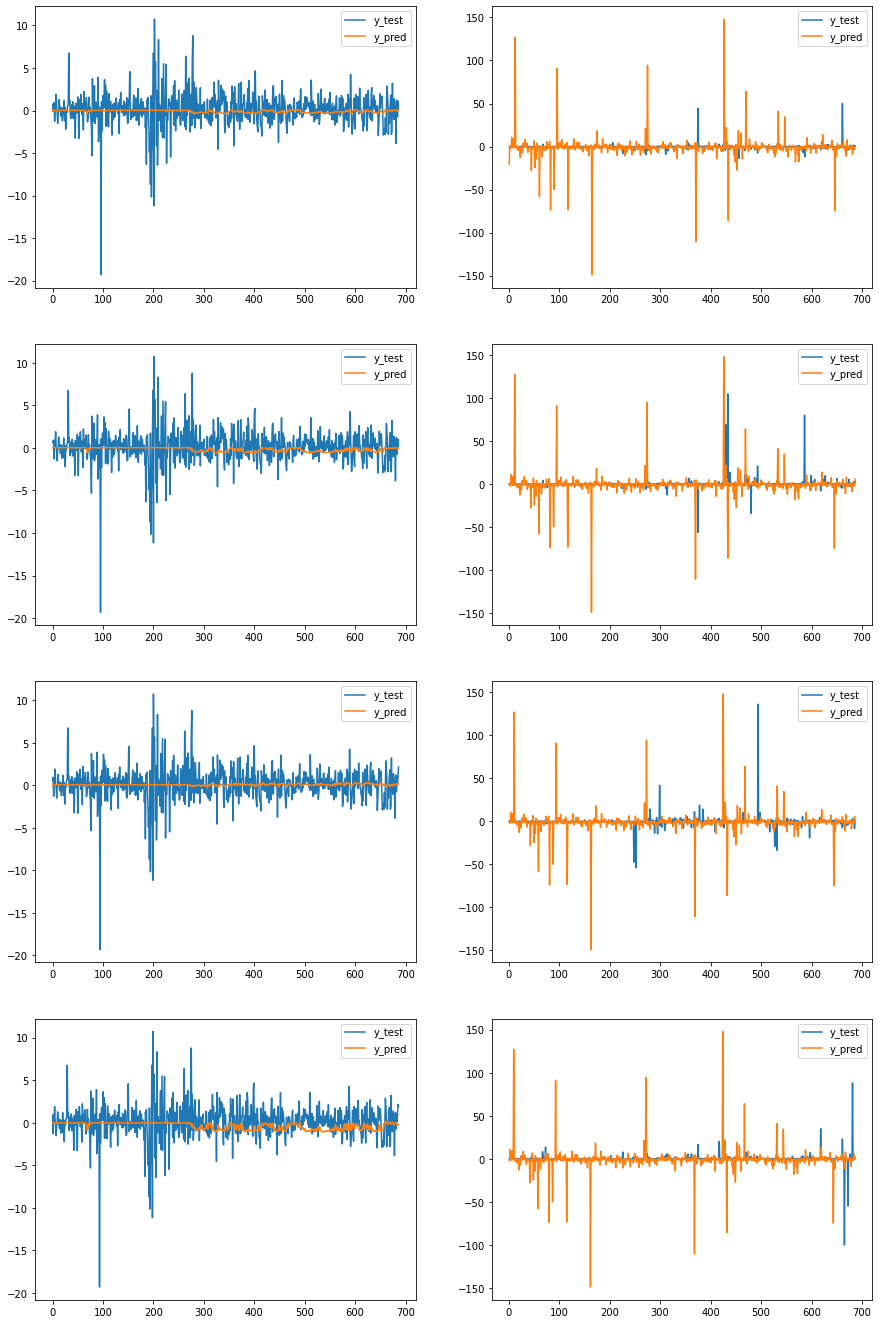

In [245]:
mpe,df_pred,y_true= evaluate(x_test, y_test, model)

In [247]:
df_pred.tail()

,0,1,2,3,4
682,-0.415690,-2.446511,0.104696,0.529159,-0.643922
683,1.541559,2.440722,0.746745,1.081175,0.903133
684,-3.425972,1.075971,-1.095375,-0.181633,-8.679570
685,-1.243036,-0.944669,-8.408472,-0.396109,-1.038856
686,1.007222,3.159381,0.526515,1.020419,3.239966


In [252]:
pd.DataFrame(y_true).tail(5)

,0,1,2,3,4
682,0.97,1.22,-0.75,1.05,0.14
683,1.22,-0.75,1.05,0.14,0.95
684,-0.75,1.05,0.14,0.95,2.16
685,1.05,0.14,0.95,2.16,1.94
686,0.14,0.95,2.16,1.94,0.69


In [231]:
#Predict Data

In [232]:
df = get_technical()
data = df [['Open','Close','Low','High','ema21','ema55','ema200','rsi','Volume','bb_upper','bb_lower','adx']]
data['Change'] = ((data['Close'] - data['Close'].shift())/data['Close'])*100
data = data.round(2)

/var/folders/8z/_088r0914q708yf3k91yqk940000gn/T/ipykernel_6531/643211816.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Change'] = ((data['Close'] - data['Close'].shift())/data['Close'])*100


In [233]:
#Feature engineering
#1. Distance from EMA
data['H_L'] = data['High']-data['Low']
data['C_O'] = data['Close']-data['Open']
data['d_ema21'] = data['Close']-data['ema21']
data['d_ema55'] = data['Close']-data['ema55']
data['d_ema200']= data['Close']-data['ema200']
data['d_bb_upper'] = data['Close']-data['bb_upper']
data['d_bb_lower'] = data['Close']-data['bb_upper']
data['d_High'] = data['Close']-data['High']
data['d_Low'] = data['Close']-data['Low']
data['d_Open'] = data['Close']-data['Open']

In [234]:
data

,Open,Close,Low,High,ema21,ema55,ema200,rsi,Volume,bb_upper,...,H_L,C_O,d_ema21,d_ema55,d_ema200,d_bb_upper,d_bb_lower,d_High,d_Low,d_Open
0,231.42,218.24,216.88,231.42,233.58,235.99,249.96,35.67,23151400.0,245.83,...,14.54,-13.18,-15.34,-17.75,-31.72,-27.59,-27.59,-13.18,1.36,-13.18
1,214.84,214.54,212.88,218.12,231.85,235.23,249.61,33.46,15705240.0,245.61,...,5.24,-0.30,-17.31,-20.69,-35.07,-31.07,-31.07,-3.58,1.66,-0.30
2,209.38,205.23,201.27,209.38,229.43,234.16,249.17,28.64,25324832.0,247.91,...,8.11,-4.15,-24.20,-28.93,-43.94,-42.68,-42.68,-4.15,3.96,-4.15
3,203.12,203.39,200.88,211.64,227.06,233.06,248.71,27.79,23517112.0,249.15,...,10.76,0.27,-23.67,-29.67,-45.32,-45.76,-45.76,-8.25,2.51,0.27
4,210.00,213.49,207.00,216.25,225.83,232.36,248.36,38.59,16262008.0,249.14,...,9.25,3.49,-12.34,-18.87,-34.87,-35.65,-35.65,-2.76,6.49,3.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3523,1695.25,1723.30,1681.00,1736.00,1729.04,1754.15,1654.78,47.69,9074499.0,1763.69,...,55.00,28.05,-5.74,-30.85,68.52,-40.39,-40.39,-12.70,42.30,28.05
3524,1697.00,1739.85,1696.00,1751.00,1730.02,1753.64,1655.63,50.54,9742588.0,1763.51,...,55.00,42.85,9.83,-13.79,84.22,-23.66,-23.66,-11.15,43.85,42.85
3525,1718.45,1778.20,1718.45,1800.00,1734.40,1754.52,1656.85,56.47,10984500.0,1773.24,...,81.55,59.75,43.80,23.68,121.35,4.96,4.96,-21.80,59.75,59.75
3526,1791.00,1813.35,1791.00,1831.60,1741.58,1756.62,1658.40,61.07,10193515.0,1791.35,...,40.60,22.35,71.77,56.73,154.95,22.00,22.00,-18.25,22.35,22.35


In [235]:
def prediction(ticker, start, end):
    
    

    #Creating Sequence to pass to the prediction
    X = data.to_numpy()[-(SEQUENCE_SIZE+1):, :]
    y = data['Change'].to_numpy()[-(SEQUENCE_SIZE+1):]
    X, y = split_timeseries(X, y, sequence_size=SEQUENCE_SIZE)


    #Model results
    results = model.predict(X)


    return results
    
    

In [236]:
import datetime
end_date = datetime.datetime.now().strftime("%Y-%m-%d")
start_date = (datetime.datetime.now() - datetime.timedelta(days=5 * 365)).strftime("%Y-%m-%d")
ticker = "AAPL"
df = get_technical()
data = df [['Open','Close','Low','High','ema21','ema55','ema200','rsi','Volume','bb_upper','bb_lower','adx']]
data['Change'] = ((data['Close'] - data['Close'].shift())/data['Close'])*100
data = data.round(2)


#Feature engineering
#1. Distance from EMA
data['H_L'] = data['High']-data['Low']
data['C_O'] = data['Close']-data['Open']
data['d_ema21'] = data['Close']-data['ema21']
data['d_ema55'] = data['Close']-data['ema55']
data['d_ema200']= data['Close']-data['ema200']
data['d_bb_upper'] = data['Close']-data['bb_upper']
data['d_bb_lower'] = data['Close']-data['bb_upper']
data['d_High'] = data['Close']-data['High']
data['d_Low'] = data['Close']-data['Low']
data['d_Open'] = data['Close']-data['Open']


data= data.drop(columns=['Open','ema21','ema55','ema200','Low','High','bb_upper','bb_lower'])
clean_data = data.dropna().tail(20)
#pred = prediction(ticker=ticker, start=start_date, end=end_date)

/var/folders/8z/_088r0914q708yf3k91yqk940000gn/T/ipykernel_6531/4138785153.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Change'] = ((data['Close'] - data['Close'].shift())/data['Close'])*100


In [237]:
X = clean_data.drop(columns=['Change']).to_numpy()


In [238]:
y = clean_data['Change'].to_numpy()

In [239]:
X.shape

(20, 14)

In [240]:
X, y = split_timeseries(X,y,sequence_size=SEQUENCE_SIZE)

i <= sequence_size+1


In [241]:
results = model.predict(X)

In [242]:
results.shape

(1, 5)

In [243]:
results.round(2)

array([[ 0.05, -0.03,  0.24, -0.27,  0.02]], dtype=float32)

# Fetch AAPL financial data

In [6]:
import pandas as pd
from bs4 import BeautifulSoup
import re
from selenium import webdriver
import chromedriver_binary
import string
pd.options.display.float_format = '{:.0f}'.format

In [7]:
is_link = 'https://finance.yahoo.com/quote/AAPL/financials?p=AAPL'
driver = webdriver.Chrome()
driver.get(is_link)
html = driver.execute_script('return document.body.innerHTML;')
soup = BeautifulSoup(html,'lxml')

In [8]:
close_price = [entry.text for entry in soup.find_all('span', {'class':'Trsdu(0.3s) Fw(b) Fz(36px) Mb(-4px) D(ib)'})]

In [9]:
close_price

[]

<html><head><script nonce="">
    if ('classList' in document.body) {
        document.body.classList.add('js');
        document.body.classList.remove('no-js');
    }
</script>
</head><body><div class="theme-2 brandtype-yahoo" id="consent-page">
<div class="consent-overlay">
<div aria-describedby="consent-text" aria-labelledby="consent-title" class="container con-container">
<div class="con-wizard">
<form action="" class="consent-form" method="post">
<div class="wizard-header"><div class="consent-brand-logo"><div class="ybar-ytheme-classic ybar-property-guce ybar-variant-yahoo _yb_7b6bj _yb_nwgl1 ybar-light ybar-track-link-views" data-issinglerowheader="false" data-issinglerowsearchbox="" data-spaceid="" data-testid="" data-version="3.8.4" id="ybar" role="banner"> <script id="ybarConfig" type="text/x-template">{}</script> <!-- --><div class="_yb_1ukfu" id="ybar-inner-wrap"><div class="_yb_uy89q _yb_2140w"><div class="_yb_1xzb4 _yb_zbxx4"> <div class="_yb_doig1"><a class="_yb_1dzop _yb